In [ ]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
# running in Google Colab to upload file
from google.colab import files
uploaded = files.upload()

Saving Titanium_Alloy_UC.csv to Titanium_Alloy_UC.csv


In [ ]:
# Load data
fatigue_df = pd.read_csv("Titanium_Alloy_UC.csv", encoding='unicode_escape')
fatigue_df.sort_values(by=['Number of Cycles'], ascending=True, ignore_index=True, inplace=True)


In [ ]:
# Prepare features and log-transformed target
drop_cols = ['Number of Cycles', 'SL. Number']
features = fatigue_df.drop(drop_cols, axis=1).astype('float64')
target = np.log10(fatigue_df['Number of Cycles'])


In [ ]:
# Split into Train (70%), Validation (15%), Test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(features, target, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)  # 0.1765 of 85% = 15%


In [ ]:
# Scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Hyperparameter tuning using validation set
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
}

best_score = -np.inf
best_params = {}


Best parameters from validation: {'max_depth': 10, 'n_estimators': 50}

Test Pearson CC: 0.968
Test R2 Score: 0.927
Test RMSE: 0.531
Test MAE: 0.344
Test Coverage: 90.9%
Median Interval Width: 0.972
Composite Metric: 0.939


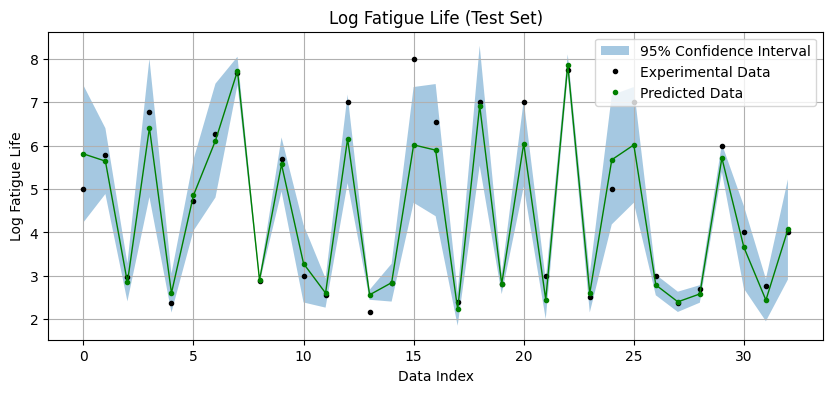

In [ ]:
for params in ParameterGrid(param_grid):
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    score = r2_score(y_val, y_val_pred)

    if score > best_score:
        best_score = score
        best_params = params

print(f"\nBest parameters from validation: {best_params}\n")

# Train best model on train + validation data
X_train_val = np.vstack([X_train, X_val])
y_train_val = np.hstack([y_train, y_val])
final_model = RandomForestRegressor(random_state=42, n_jobs=-1, **best_params)
final_model.fit(X_train_val, y_train_val)

# Predict and evaluate on test data
y_test_pred = final_model.predict(X_test)
all_tree_preds = np.array([tree.predict(X_test) for tree in final_model.estimators_])
y_pred_unc_test = np.std(all_tree_preds, axis=0)

# Metrics
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y > yL) & (y < yH)))

RMSE = sqrt(mean_squared_error(y_test, y_test_pred))
MAE = np.mean(np.abs(y_test_pred - y_test))
R2 = r2_score(y_test, y_test_pred)
Pearson = pearsonr(y_test, y_test_pred)[0]

df_low = y_test_pred - 2 * y_pred_unc_test
df_high = y_test_pred + 2 * y_pred_unc_test
interval_width = np.median(df_high - df_low)
test_coverage = coverage(y_test, df_low, df_high)
composite_metric = 0.75 * test_coverage / 100 + 0.25 * (1 / interval_width)

print(f"Test Pearson CC: {Pearson:.3f}")
print(f"Test R2 Score: {R2:.3f}")
print(f"Test RMSE: {RMSE:.3f}")
print(f"Test MAE: {MAE:.3f}")
print(f"Test Coverage: {test_coverage:.1f}%")
print(f"Median Interval Width: {interval_width:.3f}")
print(f"Composite Metric: {composite_metric:.3f}")

# Plot results
fig, ax = plt.subplots(figsize=(10, 4))
idx = np.arange(len(y_test))
ax.fill_between(idx, y_test_pred - 2*y_pred_unc_test, y_test_pred + 2*y_pred_unc_test, alpha=0.4, label='95% Confidence Interval')
ax.plot(idx, y_test.values, 'ko', label='Experimental Data', markersize=3)
ax.plot(idx, y_test_pred, 'go', label='Predicted Data', markersize=3)
ax.plot(idx, y_test_pred, '-', color='green', linewidth=1)
ax.set_title("Log Fatigue Life (Test Set)")
ax.set_xlabel("Data Index")
ax.set_ylabel("Log Fatigue Life")
ax.legend()
ax.grid(True)
plt.show()